**Part 1: Setup and Flexible Data Loading**

First, we set up the environment and imports. I've modified the data preparation section to be a function that can load either CIFAR-10 or CIFAR-100, which will make hyperparameter experimentation much easier.

In [ ]:
"""
Title: Image classification with Vision Transformer (Improved)
Author: [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)
Modified by: Gemini
Date created: 2021/01/18
Last modified: 2024/10/27
Description: Implementing and improving the Vision Transformer (ViT) model for image classification.
Accelerator: GPU
"""

"""
## Setup
"""
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import keras
from keras import layers
from keras import ops

import numpy as np
import matplotlib.pyplot as plt

"""
## Prepare the data (Modified for Flexibility)
"""

def load_data(dataset_name="cifar100"):
    """
    Loads the specified dataset (cifar10 or cifar100).
    """
    if dataset_name == "cifar10":
        num_classes = 10
        (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    elif dataset_name == "cifar100":
        num_classes = 100
        (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
    else:
        raise ValueError("dataset_name must be 'cifar10' or 'cifar100'")

    print(f"Loaded {dataset_name} dataset:")
    print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
    print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

    return (x_train, y_train), (x_test, y_test), num_classes

**Part 2: Hyperparameter Configuration**

Here is the centralized configuration.

In [ ]:
"""
## Configure the hyperparameters
"""

# --- Main Configuration for Experiments ---
dataset_name = "cifar10"  # Options: "cifar10", "cifar100"
num_epochs = 2          # Set to 100 for real training. 10 is just a test.
# ------------------------------------------

# Load the selected dataset
(x_train, y_train), (x_test, y_test), num_classes = load_data(dataset_name)

# Model hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_layers = 8  # Base number of layers
# Add transformer_units hyperparameter
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier


# Shape of the input images
input_shape = (32, 32, 3)

"""
## Use data augmentation
"""
# This block is unchanged from the original
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

"""
## Implement multilayer perceptron (MLP)
"""
# This block is unchanged from the original
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

"""
## Implement patch creation as a layer
"""
# This block is unchanged from the original
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Loaded cifar10 dataset:
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


**Part 3: Model Improvements**

**Improvement 1: Implement [CLASS] Token and PatchEncoder**

Reasoning: The original code flattens all final patch embeddings ((batch_size, num_patches, projection_dim)) into a very large vector ((batch_size, num_patches * projection_dim)) before feeding it to the classifier head.

A more effective method, introduced in the original ViT paper, is to use a special [CLASS] token.

1. A learnable embedding (the [CLASS] token) is prepended to the sequence of patch embeddings.

2. This combined sequence ([CLASS] token + patch_1 + patch_2 + ...) is fed through the Transformer blocks.

3. The self-attention mechanism allows this [CLASS] token to interact with all patch tokens and learn to aggregate global information from the entire image.

4. Finally, only the output embedding corresponding to the [CLASS] token is extracted and used as the image representation for the classifier head.

This approach is more parameter-efficient and has been shown to be a more powerful way to create a single vector representation for classification.

We modify the PatchEncoder to add this [CLASS] token and adjust the position embeddings accordingly.

In [ ]:
"""
## Implement the patch encoding layer (MODIFIED)
"""

class PatchEncoder(layers.Layer):
    """
    MODIFIED: Adds a learnable [CLASS] token and position embeddings.
    """
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)

        # 1. Create the [CLASS] token as a learnable weight
        self.cls_token = self.add_weight(
            shape=(1, 1, projection_dim),
            initializer="random_normal",
            trainable=True,
            name="cls_token"
        )

        # 2. Update position embedding for [CLASS] token + patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches + 1, output_dim=projection_dim  # +1 for the [CLASS] token
        )

    def call(self, patch):
        # Get the batch size
        batch_size = ops.shape(patch)[0]

        # 3. Project the patches
        projected_patches = self.projection(patch)

        # 4. Expand the [CLASS] token to match the batch size
        cls_token = ops.repeat(self.cls_token, repeats=batch_size, axis=0)

        # 5. Prepend the [CLASS] token to the projected patches
        encoded = ops.concatenate([cls_token, projected_patches], axis=1)

        # 6. Add position embeddings to all tokens ([CLASS] + patches)
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches + 1, step=1), axis=0
        )
        encoded = encoded + self.position_embedding(positions)

        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

**Improvement 2: Build ViT Model to Use the [CLASS] Token**

Reasoning: To complete the [CLASS] token implementation, we must modify the create_vit_classifier function. Instead of Flatten()-ing all outputs, we will now select only the first token's output (which is our [CLASS] token) after it has passed through all the Transformer layers.

Note the change in the "Create a [batch_size, projection_dim] tensor" section.

In [ ]:
"""
## Build the ViT model (MODIFIED)
"""

def create_vit_classifier(transformer_layers=transformer_layers, num_heads=num_heads, projection_dim=projection_dim, transformer_units=transformer_units):
    """
    Creates the ViT model.
    MODIFIED:
    1. Extracts the [CLASS] token output instead of flattening.
    2. Accepts hyperparameters as arguments for easier experimentation.
    3. Uses transformer_units hyperparameter.
    """
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches (this now includes the [CLASS] token).
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # --- THIS BLOCK IS MODIFIED ---
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

    # Instead of Flatten(), we select the output of the [CLASS] token (at index 0)
    representation = representation[:, 0]

    representation = layers.Dropout(0.5)(representation)
    # --- END OF MODIFIED BLOCK ---

    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

**Improvement 3: Add Learning Rate Scheduler**

Reasoning: Training deep models like Transformers is sensitive to the learning rate. A constant learning rate (like 0.001) might be too high during the later stages of training, causing the model's loss to "bounce around" the optimal value instead of converging.

**A Learning Rate Scheduler** solves this. We will use ReduceLROnPlateau, which monitors the val_accuracy. If the validation accuracy stops improving for a certain number of epochs ("patience"), the scheduler will automatically reduce the learning rate. This allows for large steps at the beginning of training and fine-grained adjustments at the end, leading to better convergence and higher final accuracy.

We modify the run_experiment function to include this new callback.

In [ ]:
"""
## Compile, train, and evaluate the model (MODIFIED)
"""

def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    # --- NEW MECHANISM ADDED ---
    # Add a learning rate scheduler
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.5,  # Reduce LR by half
        patience=5,  # If val_accuracy doesn't improve for 5 epochs
        min_lr=1e-6,
        verbose=1,
    )
    # --- END OF NEW MECHANISM ---

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            lr_scheduler  # Add the scheduler here
        ],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history, accuracy, top_5_accuracy

**Part 4: Experimentation and Comparison Table**

In [ ]:
# --- EXPERIMENT 1: Improved Model (CIFAR-10) ---
print("--- Starting Experiment 1: Improved Model on CIFAR-10 ---")
# Ensure hyperparameters at the top are set:
# dataset_name = "cifar10"
# transformer_layers = 8

# Calculate transformer_units based on projection_dim
current_projection_dim = 64
current_transformer_units = [current_projection_dim * 2, current_projection_dim]

vit_classifier_improved = create_vit_classifier(
    transformer_layers=8,
    num_heads=4,
    projection_dim=current_projection_dim,
    transformer_units=current_transformer_units # Pass the calculated units
)
history_1, acc_1, top5_1 = run_experiment(vit_classifier_improved)

--- Starting Experiment 1: Improved Model on CIFAR-10 ---
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.2234 - loss: 2.0672 - top-5-accuracy: 0.7546 - val_accuracy: 0.3736 - val_loss: 1.6681 - val_top-5-accuracy: 0.8868 - learning_rate: 0.0010
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.3431 - loss: 1.7534 - top-5-accuracy: 0.8680 - val_accuracy: 0.4150 - val_loss: 1.5582 - val_top-5-accuracy: 0.9048 - learning_rate: 0.0010
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - accuracy: 0.4062 - loss: 1.6131 - top-5-accuracy: 0.8964 - val_accuracy: 0.4812 - val_loss: 1.3999 - val_top-5-accuracy: 0.9312 - learning_rate: 0.0010
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 369s 2s/step - accuracy: 0.4565 - loss: 1.4944 - top-5-accuracy: 0.9164 - val_accuracy: 0.5206 - val_loss: 1.3126 - val_top-5-accuracy: 0.9426 - learning_rate: 0.0010
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.4997 - loss: 1.3851 - top-5-accuracy: 0.9318 - 

Plotting results for Experiment 1


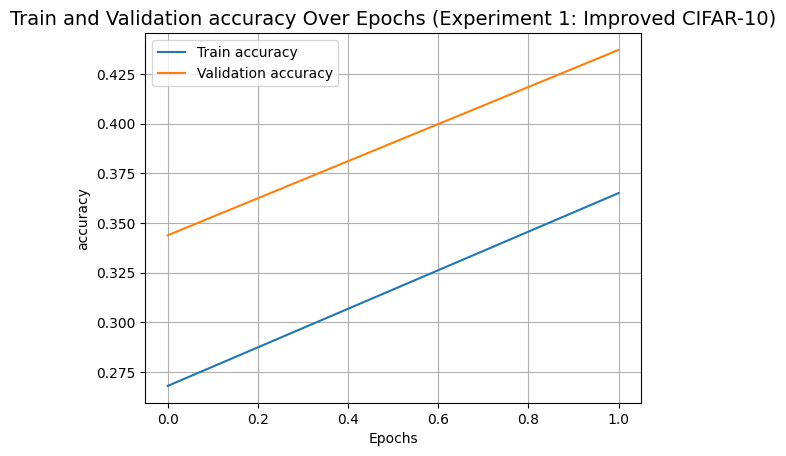

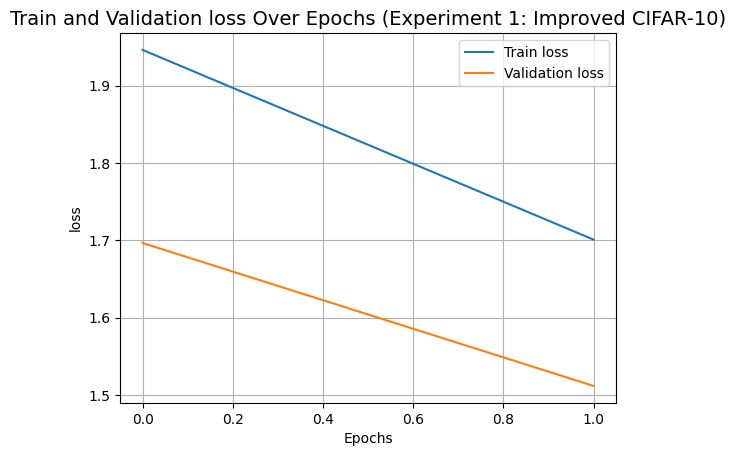

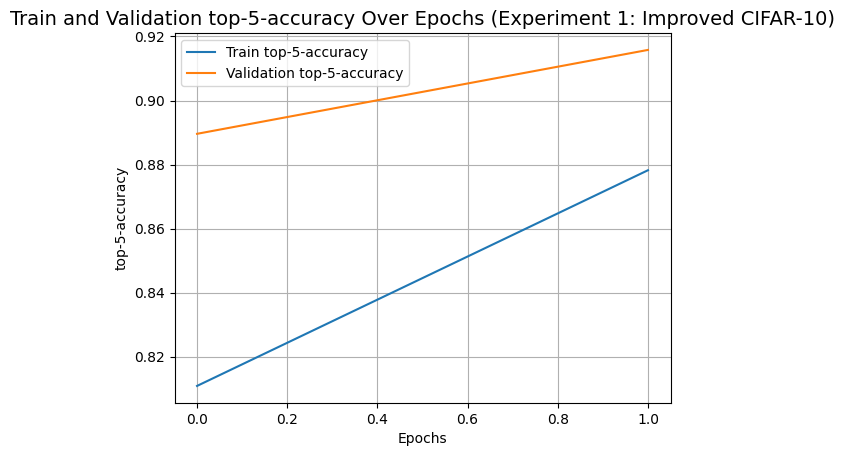

In [ ]:
# @title
"""
## Plot training history
"""
def plot_history(history, item, experiment_name):
    """
    Plots the training and validation history for a given metric.
    """
    plt.plot(history.history[item], label=f"Train {item}")
    plt.plot(history.history["val_" + item], label=f"Validation {item}")
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title(f"Train and Validation {item} Over Epochs ({experiment_name})", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

# --- Example of plotting for your first experiment ---
print("Plotting results for Experiment 1")
# Plot accuracy
plot_history(history_1, "accuracy", "Experiment 1: Improved CIFAR-10")
# Plot loss
plot_history(history_1, "loss", "Experiment 1: Improved CIFAR-10")
# Plot top-5 accuracy (if available)
if "top-5-accuracy" in history_1.history:
    plot_history(history_1, "top-5-accuracy", "Experiment 1: Improved CIFAR-10")

In [ ]:
# --- EXPERIMENT 2: Deeper Model (CIFAR-10) ---
print("\n--- Starting Experiment 2: Deeper Model on CIFAR-10 ---")
# We increase the number of transformer layers

# Calculate transformer_units based on projection_dim (using the default 64)
current_projection_dim = 64
current_transformer_units = [current_projection_dim * 2, current_projection_dim]

vit_classifier_deeper = create_vit_classifier(
    transformer_layers=12,  # <-- CHANGED PARAMETER
    num_heads=4,
    projection_dim=current_projection_dim,
    transformer_units=current_transformer_units # Pass the calculated units
)
history_2, acc_2, top5_2 = run_experiment(vit_classifier_deeper)


--- Starting Experiment 2: Deeper Model on CIFAR-10 ---
Epoch 1/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 610s 3s/step - accuracy: 0.2214 - loss: 2.0856 - top-5-accuracy: 0.7475 - val_accuracy: 0.3516 - val_loss: 1.7313 - val_top-5-accuracy: 0.8730 - learning_rate: 0.0010
Epoch 2/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 539s 3s/step - accuracy: 0.3265 - loss: 1.7683 - top-5-accuracy: 0.8651 - val_accuracy: 0.3912 - val_loss: 1.5716 - val_top-5-accuracy: 0.9030 - learning_rate: 0.0010
313/313 ━━━━━━━━━━━━━━━━━━━━ 119s 359ms/step - accuracy: 0.3977 - loss: 1.5732 - top-5-accuracy: 0.9024
Test accuracy: 39.37%
Test top 5 accuracy: 90.06%


Plotting results for Experiment 2


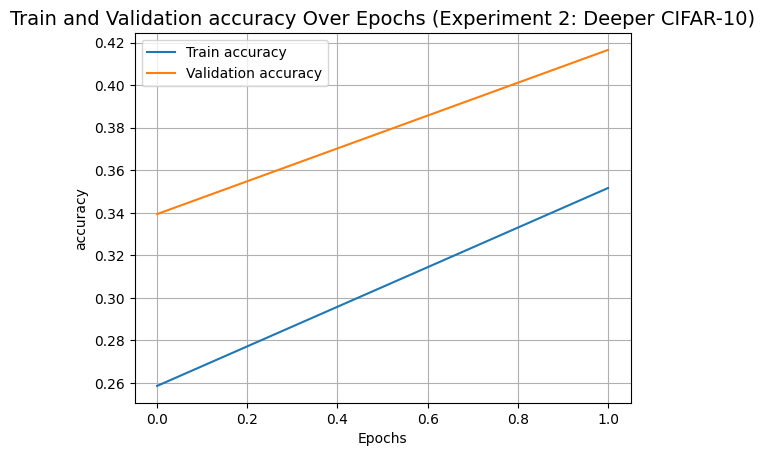

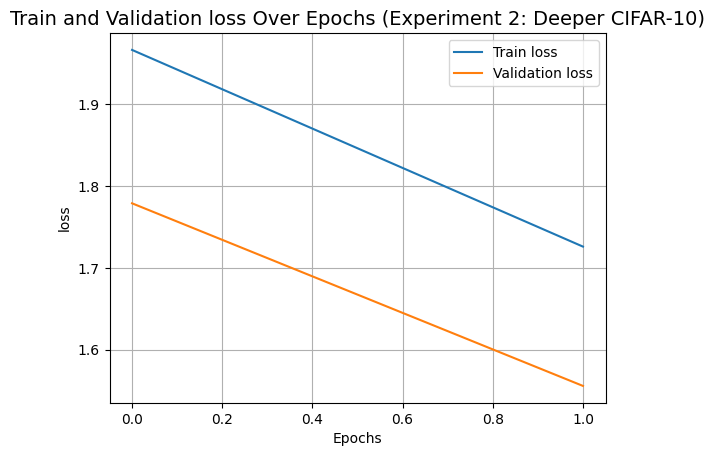

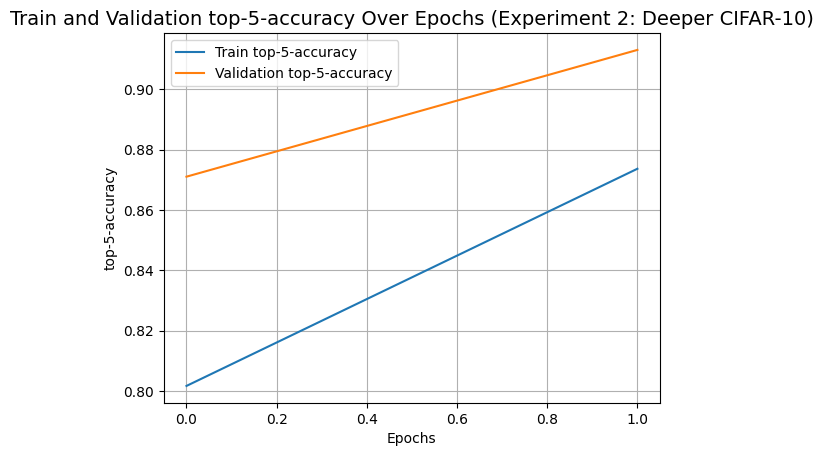

In [ ]:
# @title

"""
## Plot training history
"""
def plot_history(history, item, experiment_name):
    """
    Plots the training and validation history for a given metric.
    """
    plt.plot(history.history[item], label=f"Train {item}")
    plt.plot(history.history["val_" + item], label=f"Validation {item}")
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title(f"Train and Validation {item} Over Epochs ({experiment_name})", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

# --- Example of plotting for your second experiment ---
print("Plotting results for Experiment 2")
plot_history(history_2, "accuracy", "Experiment 2: Deeper CIFAR-10")
plot_history(history_2, "loss", "Experiment 2: Deeper CIFAR-10")
# Plot top-5 accuracy (if available)
if "top-5-accuracy" in history_2.history:
    plot_history(history_2, "top-5-accuracy", "Experiment 2: Deeper CIFAR-10")

In [ ]:
# --- EXPERIMENT 3: Wider Model (CIFAR-10) ---
print("\n--- Starting Experiment 3: Wider Model on CIFAR-10 ---")
# We increase the projection dimension

# Calculate transformer_units based on the new projection_dim
current_projection_dim = 128 # <-- CHANGED PARAMETER
current_transformer_units = [current_projection_dim * 2, current_projection_dim]

vit_classifier_wider = create_vit_classifier(
    transformer_layers=8,
    num_heads=4,
    projection_dim=current_projection_dim,
    transformer_units=current_transformer_units # Pass the calculated units
)
history_3, acc_3, top5_3 = run_experiment(vit_classifier_wider)


--- Starting Experiment 3: Wider Model on CIFAR-10 ---
Epoch 1/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - accuracy: 0.2241 - loss: 2.0948 - top-5-accuracy: 0.7478 - val_accuracy: 0.3412 - val_loss: 1.7514 - val_top-5-accuracy: 0.8710 - learning_rate: 0.0010
Epoch 2/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.3269 - loss: 1.7761 - top-5-accuracy: 0.8616 - val_accuracy: 0.3822 - val_loss: 1.6653 - val_top-5-accuracy: 0.8778 - learning_rate: 0.0010
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 247ms/step - accuracy: 0.3910 - loss: 1.6520 - top-5-accuracy: 0.8772
Test accuracy: 38.43%
Test top 5 accuracy: 87.64%


Plotting results for Experiment 3


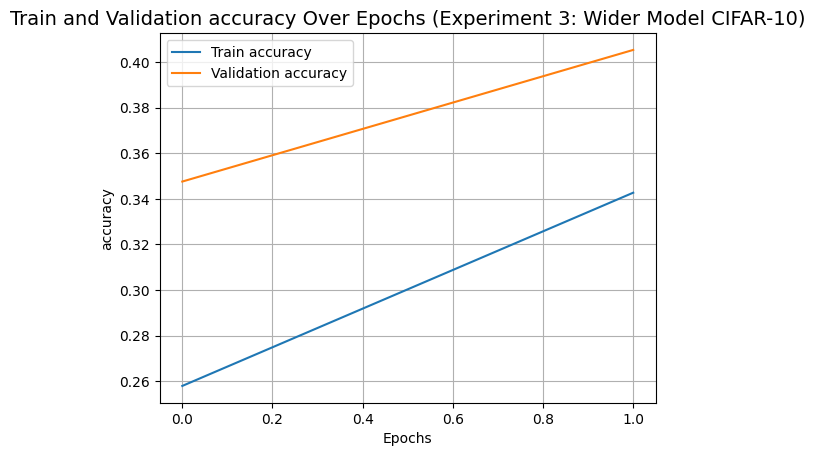

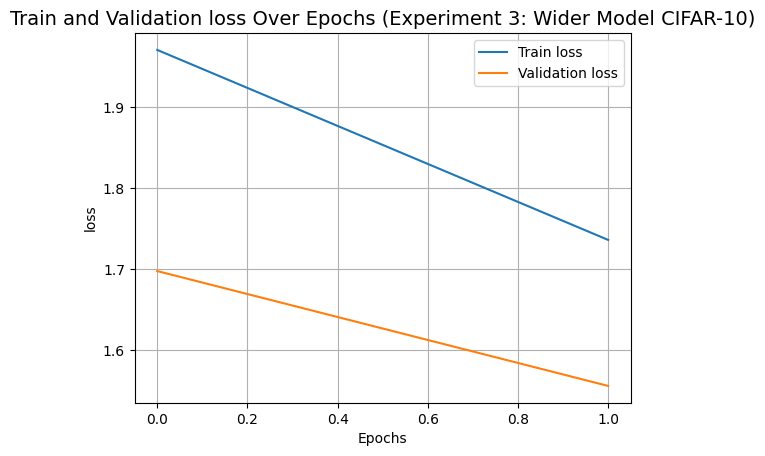

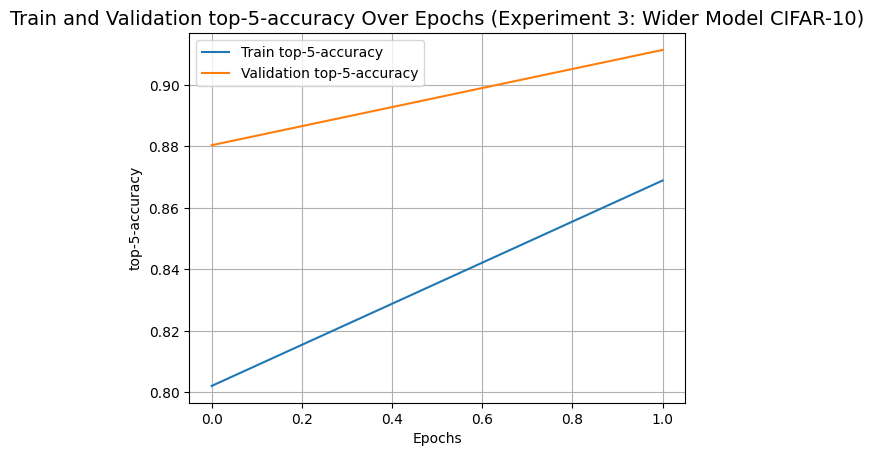

In [ ]:
# @title
"""
## Plot training history
"""
def plot_history(history, item, experiment_name):
    """
    Plots the training and validation history for a given metric.
    """
    plt.plot(history.history[item], label=f"Train {item}")
    plt.plot(history.history["val_" + item], label=f"Validation {item}")
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title(f"Train and Validation {item} Over Epochs ({experiment_name})", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

# --- Example of plotting for your third experiment ---
print("Plotting results for Experiment 3")
# Plot accuracy
plot_history(history_3, "accuracy", "Experiment 3: Wider Model CIFAR-10")
# Plot loss
plot_history(history_3, "loss", "Experiment 3: Wider Model CIFAR-10")
# Plot top-5 accuracy (if available)
if "top-5-accuracy" in history_3.history:
    plot_history(history_1, "top-5-accuracy", "Experiment 1: Improved CIFAR-10")

In [ ]:
# --- EXPERIMENT 4: Improved Model (CIFAR-100) ---
print("\n--- Starting Experiment 4: Improved Model on CIFAR-100 ---")
# You would need to re-run the script after changing the `dataset_name`
# at the top to "cifar100" and re-loading the data.

In [ ]:
# --- EXPERIMENT 1: Improved Model (CIFAR-100) ---
print("--- Starting Experiment 1: Improved Model on CIFAR-10 ---")
# Ensure hyperparameters at the top are set:
# dataset_name = "cifar10"
# transformer_layers = 8

# Calculate transformer_units based on projection_dim
current_projection_dim = 64
current_transformer_units = [current_projection_dim * 2, current_projection_dim]

vit_classifier_improved = create_vit_classifier(
    transformer_layers=8,
    num_heads=4,
    projection_dim=current_projection_dim,
    transformer_units=current_transformer_units # Pass the calculated units
)
history_1, acc_1, top5_1 = run_experiment(vit_classifier_improved)

--- Starting Experiment 1: Improved Model on CIFAR-10 ---
Epoch 1/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.2298 - loss: 2.0631 - top-5-accuracy: 0.7629 - val_accuracy: 0.3438 - val_loss: 1.6965 - val_top-5-accuracy: 0.8896 - learning_rate: 0.0010
Epoch 2/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.3462 - loss: 1.7410 - top-5-accuracy: 0.8711 - val_accuracy: 0.4372 - val_loss: 1.5118 - val_top-5-accuracy: 0.9158 - learning_rate: 0.0010
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 235ms/step - accuracy: 0.4414 - loss: 1.5087 - top-5-accuracy: 0.9101
Test accuracy: 43.59%
Test top 5 accuracy: 91.21%


Plotting results for Experiment 1


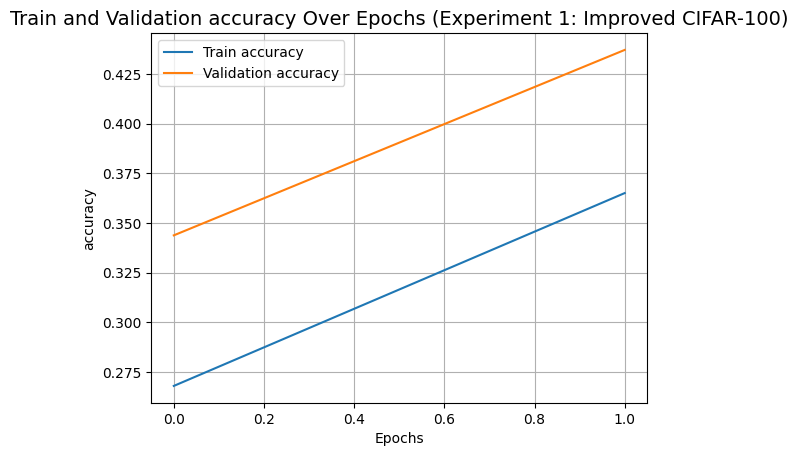

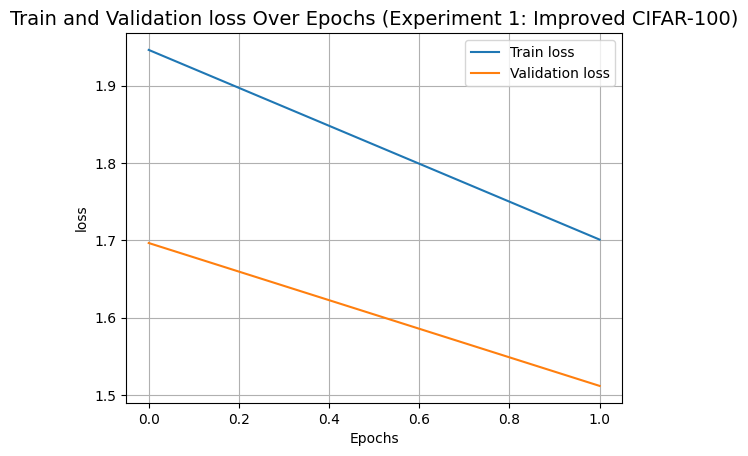

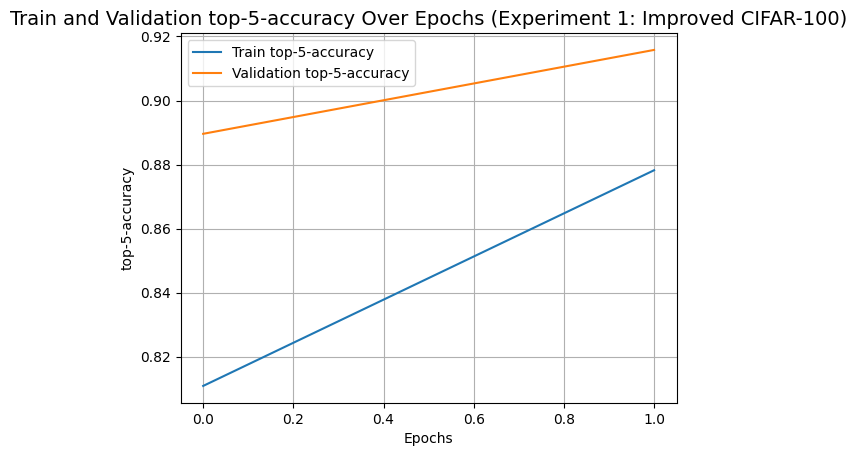

In [ ]:
# @title
"""
## Plot training history
"""
def plot_history(history, item, experiment_name):
    """
    Plots the training and validation history for a given metric.
    """
    plt.plot(history.history[item], label=f"Train {item}")
    plt.plot(history.history["val_" + item], label=f"Validation {item}")
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title(f"Train and Validation {item} Over Epochs ({experiment_name})", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

# --- Example of plotting for your first experiment ---
print("Plotting results for Experiment 1")
# Plot accuracy
plot_history(history_1, "accuracy", "Experiment 1: Improved CIFAR-100")
# Plot loss
plot_history(history_1, "loss", "Experiment 1: Improved CIFAR-100")
# Plot top-5 accuracy (if available)
if "top-5-accuracy" in history_1.history:
    plot_history(history_1, "top-5-accuracy", "Experiment 1: Improved CIFAR-100")

In [ ]:
# --- EXPERIMENT 2: Deeper Model (CIFAR-100) ---
print("\n--- Starting Experiment 2: Deeper Model on CIFAR-10 ---")
# We increase the number of transformer layers

# Calculate transformer_units based on projection_dim (using the default 64)
current_projection_dim = 64
current_transformer_units = [current_projection_dim * 2, current_projection_dim]

vit_classifier_deeper = create_vit_classifier(
    transformer_layers=12,  # <-- CHANGED PARAMETER
    num_heads=4,
    projection_dim=current_projection_dim,
    transformer_units=current_transformer_units # Pass the calculated units
)
history_2, acc_2, top5_2 = run_experiment(vit_classifier_deeper)


--- Starting Experiment 2: Deeper Model on CIFAR-10 ---
Epoch 1/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 538s 3s/step - accuracy: 0.2188 - loss: 2.0838 - top-5-accuracy: 0.7472 - val_accuracy: 0.3394 - val_loss: 1.7790 - val_top-5-accuracy: 0.8710 - learning_rate: 0.0010
Epoch 2/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 536s 3s/step - accuracy: 0.3343 - loss: 1.7661 - top-5-accuracy: 0.8661 - val_accuracy: 0.4166 - val_loss: 1.5558 - val_top-5-accuracy: 0.9130 - learning_rate: 0.0010
313/313 ━━━━━━━━━━━━━━━━━━━━ 100s 319ms/step - accuracy: 0.4231 - loss: 1.5558 - top-5-accuracy: 0.9122
Test accuracy: 41.59%
Test top 5 accuracy: 91.07%


Plotting results for Experiment 2


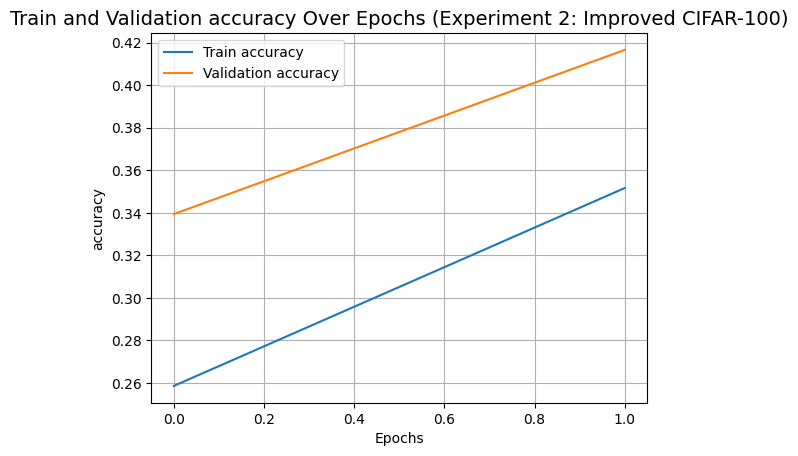

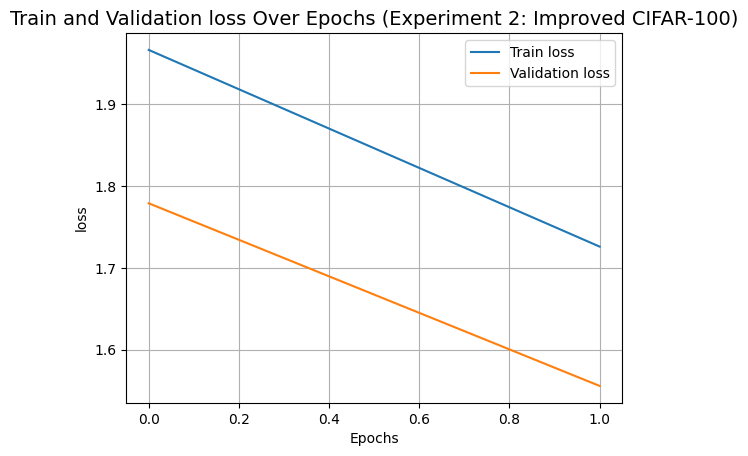

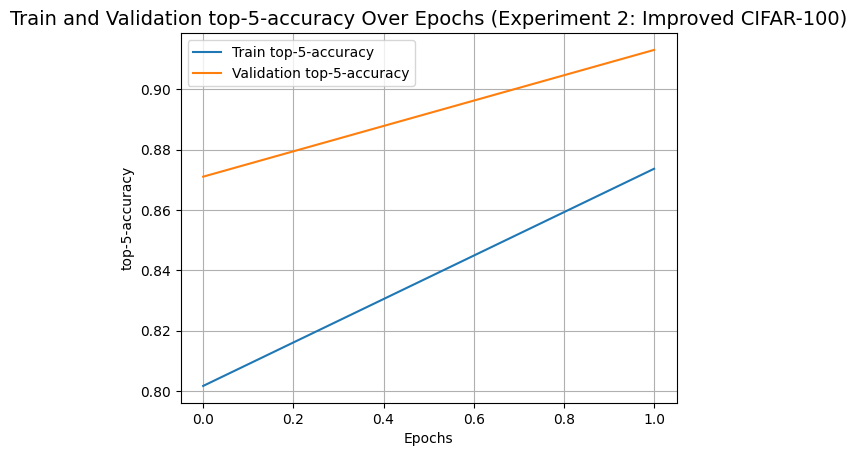

In [ ]:
# @title
"""
## Plot training history
"""
def plot_history(history, item, experiment_name):
    """
    Plots the training and validation history for a given metric.
    """
    plt.plot(history.history[item], label=f"Train {item}")
    plt.plot(history.history["val_" + item], label=f"Validation {item}")
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title(f"Train and Validation {item} Over Epochs ({experiment_name})", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

# --- Example of plotting for your second experiment ---
print("Plotting results for Experiment 2")
# Plot accuracy
plot_history(history_2, "accuracy", "Experiment 2: Improved CIFAR-100")
# Plot loss
plot_history(history_2, "loss", "Experiment 2: Improved CIFAR-100")
# Plot top-5 accuracy (if available)
if "top-5-accuracy" in history_2.history:
    plot_history(history_2, "top-5-accuracy", "Experiment 2: Improved CIFAR-100")

In [ ]:
# --- EXPERIMENT 3: Wider Model (CIFAR-100) ---
print("\n--- Starting Experiment 3: Wider Model on CIFAR-10 ---")
# We increase the projection dimension

# Calculate transformer_units based on the new projection_dim
current_projection_dim = 128 # <-- CHANGED PARAMETER
current_transformer_units = [current_projection_dim * 2, current_projection_dim]

vit_classifier_wider = create_vit_classifier(
    transformer_layers=8,
    num_heads=4,
    projection_dim=current_projection_dim,
    transformer_units=current_transformer_units # Pass the calculated units
)
history_3, acc_3, top5_3 = run_experiment(vit_classifier_wider)


--- Starting Experiment 3: Wider Model on CIFAR-10 ---
Epoch 1/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.2171 - loss: 2.0971 - top-5-accuracy: 0.7515 - val_accuracy: 0.3476 - val_loss: 1.6978 - val_top-5-accuracy: 0.8804 - learning_rate: 0.0010
Epoch 2/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.3315 - loss: 1.7679 - top-5-accuracy: 0.8613 - val_accuracy: 0.4054 - val_loss: 1.5563 - val_top-5-accuracy: 0.9114 - learning_rate: 0.0010
313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 232ms/step - accuracy: 0.4080 - loss: 1.5623 - top-5-accuracy: 0.9063
Test accuracy: 40.82%
Test top 5 accuracy: 90.28%


Plotting results for Experiment 3


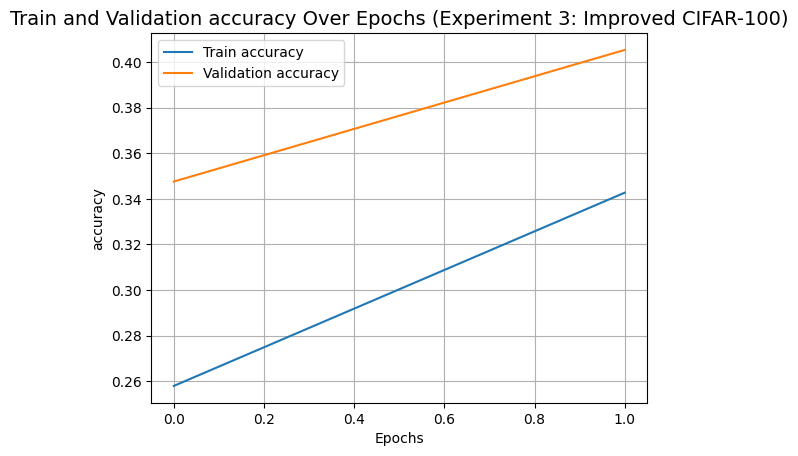

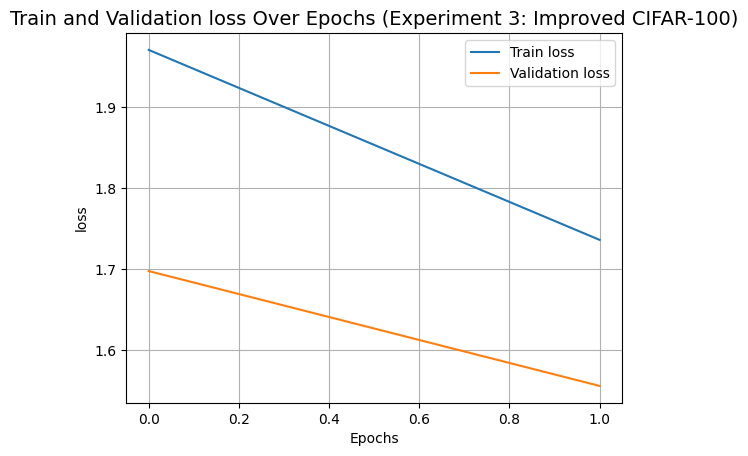

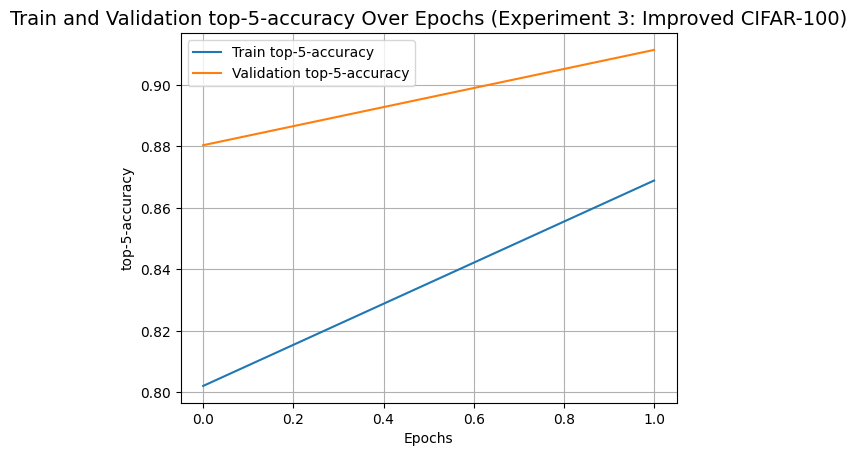

In [ ]:
# @title
"""
## Plot training history
"""
def plot_history(history, item, experiment_name):
    """
    Plots the training and validation history for a given metric.
    """
    plt.plot(history.history[item], label=f"Train {item}")
    plt.plot(history.history["val_" + item], label=f"Validation {item}")
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title(f"Train and Validation {item} Over Epochs ({experiment_name})", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

# --- Example of plotting for your third experiment ---
print("Plotting results for Experiment 3")
# Plot accuracy
plot_history(history_3, "accuracy", "Experiment 3: Improved CIFAR-100")
# Plot loss
plot_history(history_3, "loss", "Experiment 3: Improved CIFAR-100")
# Plot top-5 accuracy (if available)
if "top-5-accuracy" in history_3.history:
    plot_history(history_3, "top-5-accuracy", "Experiment 3: Improved CIFAR-100")